### **Load libraries**

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Define ticker names**

In [4]:
col_stock_list_path = 'colombia_stocks_trii.csv'
global_stock_list_path = 'global_stocks_trii.csv'

ticker_list_col = list(pd.read_csv(col_stock_list_path, header=None)[0])
ticker_list_glob = list(pd.read_csv(global_stock_list_path, header=None)[0])

In [5]:
""" Alt method
col_stock_list_path = 'colombia_stocks_trii.csv'
global_stock_list_path = 'global_stocks_trii.csv'

with open(col_stock_list_path) as s:
    ticker_list_col = []
    [ticker_list_col.append(l.replace('\n', '')) for l in s]
    s.close()
with open(global_stock_list_path) as s:
    ticker_list_global = []
    [ticker_list_global.append(l.replace('\n', '')) for l in s]
    s.close()
"""

" Alt method\ncol_stock_list_path = 'colombia_stocks_trii.csv'\nglobal_stock_list_path = 'global_stocks_trii.csv'\n\nwith open(col_stock_list_path) as s:\n    ticker_list_col = []\n    [ticker_list_col.append(l.replace('\n', '')) for l in s]\n    s.close()\nwith open(global_stock_list_path) as s:\n    ticker_list_global = []\n    [ticker_list_global.append(l.replace('\n', '')) for l in s]\n    s.close()\n"

### **Extract data from YFinance**

In [6]:
days_of_data = 790
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=days_of_data)

In [7]:
interval = '1wk'  # Uncomment for weekly data
# interval = '1mo' # Uncomment for monthly data

col_stocks_raw = yf.download(ticker_list_col, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']
global_stocks_raw = yf.download(ticker_list_glob, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']

[*********************100%***********************]  37 of 37 completed

3 Failed downloads:
['LTMCO.CL', 'GXTESCOL.CL', 'NUAMCO.CL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1wk 2022-09-20 -> 2024-11-18)')
[*********************100%***********************]  47 of 49 completed

9 Failed downloads:
['ENELAMCO.CL', 'IWVLM.XD', 'SQMBCO.CL', 'ICHNA.XD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1wk 2022-09-20 -> 2024-11-18)')
['LTMCO', 'CFMITNIPCO', 'IBO1']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['JNJ', 'IUES.SW']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
[*********************100%***********************]  47 of 49 completed

### **Preprocessing**

In [8]:
# Assign a frequency to the index of the dataframes
col_stocks_raw.index = col_stocks_raw.index.to_period(freq='W') # Uncomment to set frequency as Weekly
global_stocks_raw.index = global_stocks_raw.index.to_period(freq='W') # Uncomment to set ferquency as Weekly

# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly

C:\Users\jumar\AppData\Local\Temp\ipykernel_26488\1577141145.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  col_stocks_raw.index = col_stocks_raw.index.to_period(freq='W') # Uncomment to set frequency as Weekly
C:\Users\jumar\AppData\Local\Temp\ipykernel_26488\1577141145.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  global_stocks_raw.index = global_stocks_raw.index.to_period(freq='W') # Uncomment to set ferquency as Weekly


In [9]:
# Convert from prices into returns
col_rets_raw = col_stocks_raw.pct_change().iloc[1:].dropna(axis='columns')
global_rets_raw = global_stocks_raw.pct_change().iloc[1:].dropna(axis='columns')

C:\Users\jumar\AppData\Local\Temp\ipykernel_26488\3779391522.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  col_rets_raw = col_stocks_raw.pct_change().iloc[1:].dropna(axis='columns')
C:\Users\jumar\AppData\Local\Temp\ipykernel_26488\3779391522.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  global_rets_raw = global_stocks_raw.pct_change().iloc[1:].dropna(axis='columns')


In [10]:
# Define start and end dates of the analysis
days_of_analysis = 7*108
end_date = str(datetime.date.today())
start_date = str(datetime.date.today() - datetime.timedelta(days=days_of_analysis))

In [11]:
# Filter for only dates according to the start and end date
col_rets = col_rets_raw.loc[start_date:end_date].dropna(axis='columns')
global_rets = global_rets_raw.loc[start_date:end_date].dropna(axis='columns')

col_stocks = col_stocks_raw.loc[start_date:end_date].dropna(axis='columns')
global_stocks = global_stocks_raw.loc[start_date:end_date].dropna(axis='columns')

In [12]:
# Merge Col and Global stock prices and returns data
rets = pd.concat([col_rets, global_rets], axis='columns')
stocks = pd.concat([col_stocks, global_stocks], axis='columns')

### **Initial examination**

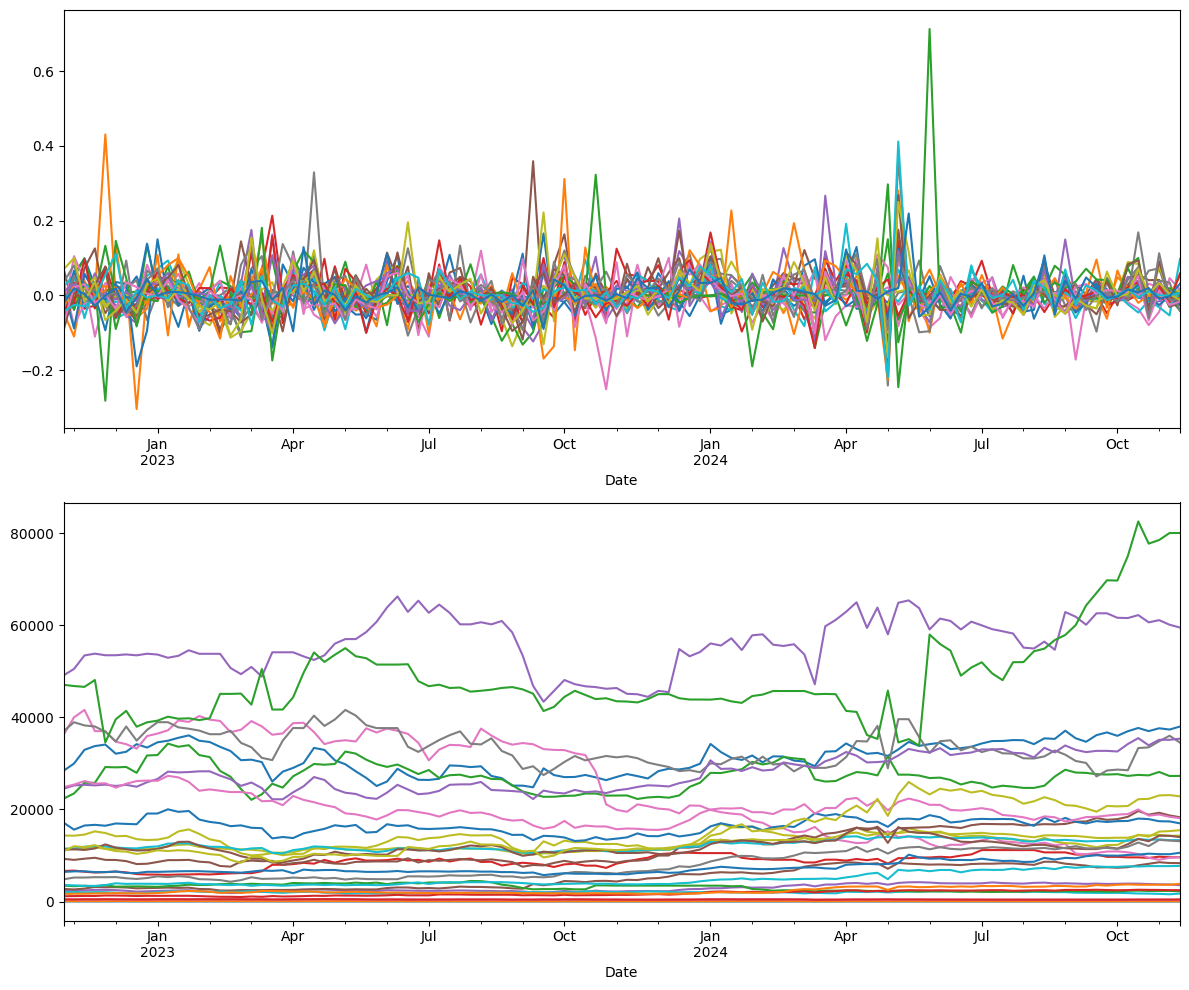

In [13]:
df1_to_plot = col_rets
df2_to_plot = col_stocks

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
df1_to_plot.plot(ax = axes[0], legend=False)
df2_to_plot.plot(ax=axes[1], legend=False)
plt.tight_layout()

In [14]:
summary_stats = rk.summary_stats(rets)
summary_stats

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
BCOLOMBIA.CL,0.032339,0.158701,0.710547,4.929819,0.060200,0.077796,0.014157,-0.312086
BHI.CL,0.050963,0.212355,2.123583,28.234747,0.021475,0.106856,0.095826,-0.325008
BOGOTA.CL,0.012034,0.168238,0.304869,4.505118,0.071947,0.107364,-0.104135,-0.355890
BVC.CL,0.043477,0.164471,0.901188,6.258508,0.057437,0.086076,0.079555,-0.222798
CELSIA.CL,0.048611,0.178465,0.734704,4.087837,0.067071,0.087566,0.101285,-0.273808
CEMARGOS.CL,0.140348,0.205823,2.042847,12.919130,0.034038,0.088087,0.521616,-0.245765
CNEC.CL,-0.141106,0.192909,-0.656278,5.710567,0.109465,0.146311,-0.863316,-0.781722
CONCONCRET.CL,0.031918,0.197014,1.978381,11.394958,0.043613,0.080848,0.009261,-0.304041
CORFICOLCF.CL,0.008638,0.185886,0.818574,4.951597,0.070869,0.093811,-0.112060,-0.360412


### **Technical Indicators for selected stock**

,PBR,SMA8,EMA8,SMA8 Signal,EMA8 Signal,MACD Signal
Date,,,,,,
2022-10-24/2022-10-30,8.367349,NaN,8.367349,False,False,False
2022-10-31/2022-11-06,7.869662,NaN,8.256752,False,False,False
2022-11-07/2022-11-13,7.191565,NaN,8.020043,False,False,False
2022-11-14/2022-11-20,7.060922,NaN,7.806905,False,False,False
2022-11-21/2022-11-27,6.407710,NaN,7.495973,False,False,False
...,...,...,...,...,...,...
2024-10-14/2024-10-20,14.160000,14.69750,14.550361,False,False,False
2024-10-21/2024-10-27,13.790000,14.51750,14.381392,False,False,False
2024-10-28/2024-11-03,13.110000,14.31250,14.098860,False,False,False


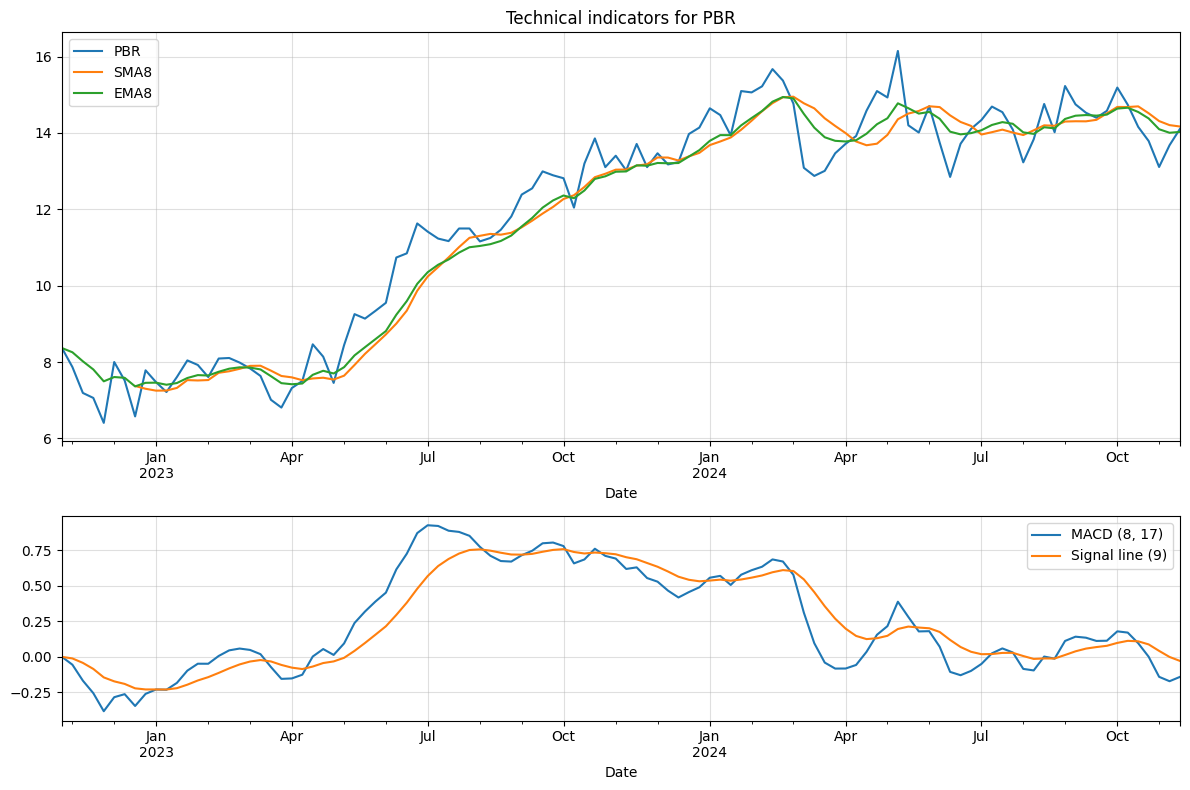

In [15]:
stock = 'PBR'#'GE'
rk.technical_indicators(stocks[stock], time_window=8, return_df=True, indicators=['SMA', 'EMA', 'MACD'], macd_params=[8, 17, 9])

### **Signals across all stocks**

In [16]:
signals = []
for stock in stocks.columns:
    stock_signals = rk.technical_indicators(stocks[stock], indicators=['SMA', 'EMA', 'MACD'], time_window=8, macd_params=[8, 17, 9], return_df=True, plot=False).iloc[-1]
    stock_signals = pd.DataFrame(stock_signals).T
    stock_signals.index = [stock]
    stock_signals.rename(columns={stock: 'Price'}, inplace=True)
    signals.append(stock_signals)

signals = pd.concat(signals, axis=0)

In [17]:
signals

,Price,SMA8,EMA8,SMA8 Signal,EMA8 Signal,MACD Signal
BCOLOMBIA.CL,38000.0,37165.084473,37143.521949,True,True,True
BHI.CL,305.0,305.125,304.841047,False,True,False
BOGOTA.CL,27280.0,27510.890137,27430.981484,False,False,False
BVC.CL,9620.0,9635.0,9739.852584,False,False,False
CELSIA.CL,3565.0,3790.508545,3764.035716,False,False,False
CEMARGOS.CL,8350.0,7948.364014,8135.837548,True,True,True
CNEC.CL,9640.0,10062.5,10005.538195,False,False,False
CONCONCRET.CL,305.0,287.0,292.752582,True,True,True
CORFICOLCF.CL,15500.0,14075.0,14414.874836,True,True,True
ECOPETROL.CL,1745.0,1766.25,1762.706579,False,False,False


### **Stock filtering by signal**

In [18]:
signals_filtered = signals[signals['MACD Signal'] == True]

In [19]:
selected_stocks_rets = rets[signals_filtered.index]
selected_stocks_stocks = stocks[signals_filtered.index]

### **Export datasets and an index for the Sharpe-Ratio maximizing allocation**

In [20]:
# Selected stocks dataset
selected_stocks_rets.to_csv('selected_stocks_rets.csv')
selected_stocks_stocks.to_csv('selected_stocks_stocks.csv')

# Raw data datasets
col_rets_raw.to_csv('col_rets_raw.csv')
global_rets_raw.to_csv('global_rets_raw.csv')

# Pre-processed datasets
col_rets.to_csv('col_rets.csv')
global_rets.to_csv('global_rets.csv')

col_stocks.to_csv('col_stocks.csv')
global_stocks.to_csv('global_stocks.csv')

# Concatenated returns and stock prices datasets
rets.to_csv('all_rets.csv')
stocks.to_csv('all_stocks.csv')